In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import nltk
import unicodedata
seed = 208
import re

In [2]:
# Load data
f = open('../data/train.json','r', encoding = 'utf-8')
data = pd.read_json(f)
data

id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...
...      ...          ...                                                ...
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...

[39774 rows x 3 columns]

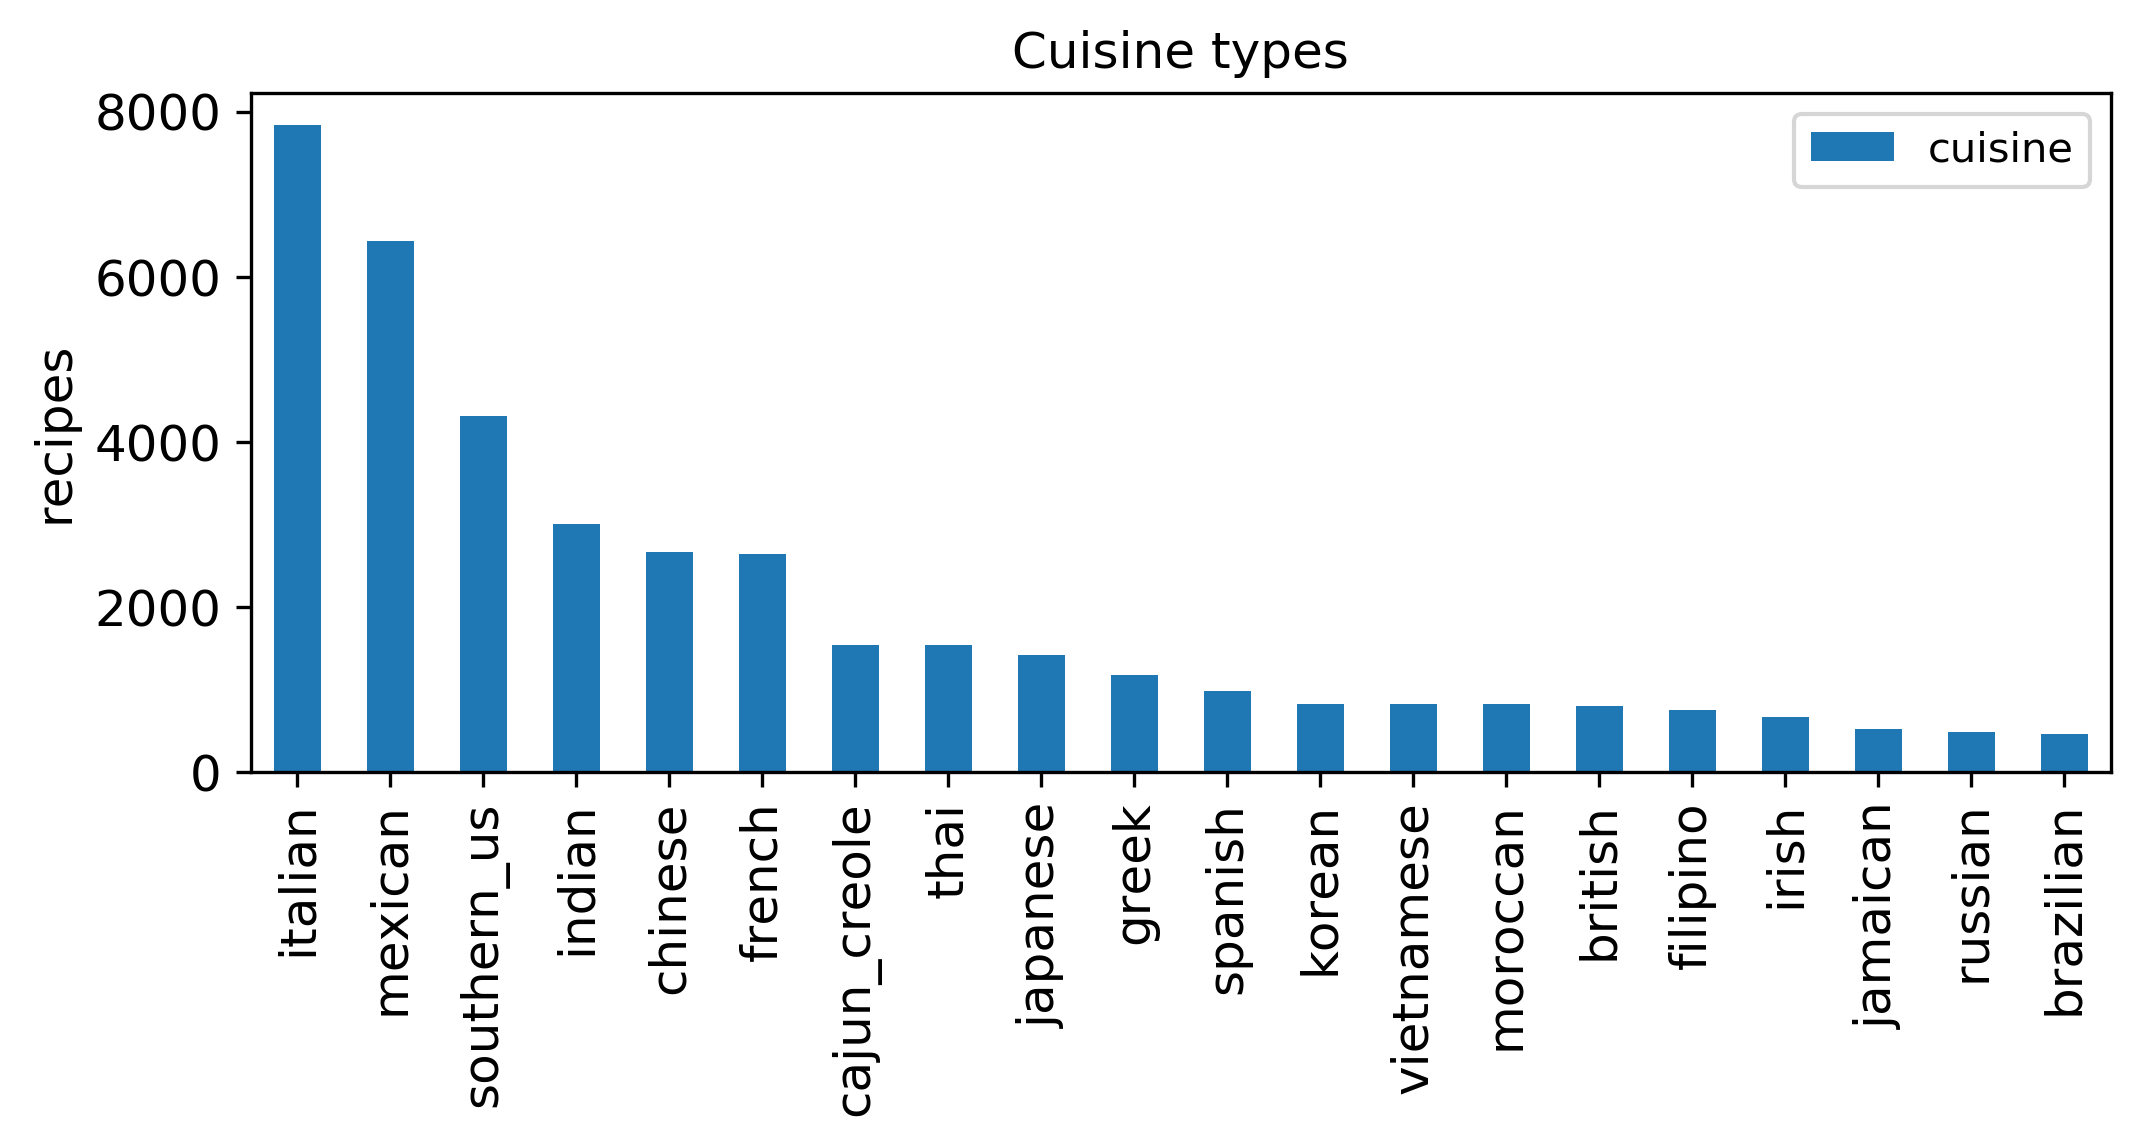

In [31]:
# Visualize the number of cuisines 
plt.figure(dpi=300)
ax = data['cuisine'].value_counts().plot(kind='bar', title ="Cuisine types", figsize=(8, 3), legend=True, fontsize=12)
ax.set_ylabel("recipes", fontsize=12)
plt.show()

In [6]:
# Reformat the documents for vectorization
from nltk.stem import WordNetLemmatizer
wpt = nltk.WordPunctTokenizer()
corpus = [' '.join(doc) for doc in data["ingredients"]]
corpus1 = [wpt.tokenize(line) for line in corpus]
corpus2 = []
lemmatizer = WordNetLemmatizer()
for cuisine in corpus1:
    p = [lemmatizer.lemmatize(tok,pos='n')for tok in cuisine]
    p0 = [unicodedata.normalize('NFKD', tok).encode('ascii', 'ignore').decode('utf-8', 'ignore') for tok in p]
    p1 = [re.sub(r'[^a-zA-Z\s]', '', tok, re.I|re.A) for tok in p0]
    p3 = ' '.join(p1)
    corpus2.append(p3)
corpus2

['romaine lettuce black olive grape tomato garlic pepper purple onion seasoning garbanzo bean feta cheese crumbles',
 'plain flour ground pepper salt tomato ground black pepper thyme egg green tomato yellow corn meal milk vegetable oil',
 'egg pepper salt mayonaise cooking oil green chilies grilled chicken breast garlic powder yellow onion soy sauce butter chicken liver',
 'water vegetable oil wheat salt',
 'black pepper shallot cornflour cayenne pepper onion garlic paste milk butter salt lemon juice water chili powder passata oil ground cumin boneless chicken skinless thigh garam masala double cream natural yogurt bay leaf',
 'plain flour sugar butter egg fresh ginger root salt ground cinnamon milk vanilla extract ground ginger powdered sugar baking powder',
 'olive oil salt medium shrimp pepper garlic chopped cilantro jalapeno chilies flat leaf parsley skirt steak white vinegar sea salt bay leaf chorizo sausage',
 'sugar pistachio nut white almond bark flour vanilla extract olive oil

In [7]:
# convert text to word frequency vectors with TfidfVectorizer.
vectorizer = TfidfVectorizer() 
tfidf = vectorizer.fit_transform(corpus2)
#pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf.shape

(39774, 2808)

In [14]:
# convert text to word count vectors with CountVectorizer.
vec = CountVectorizer()
X = vec.fit_transform(corpus2)
dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(dtm.columns)

Index(['abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent',
       'accompaniment', 'achiote', 'acid', 'acinus',
       ...
       'yuzukosho', 'za', 'zatarain', 'zatarains', 'zero', 'zest', 'zesty',
       'zinfandel', 'ziti', 'zucchini'],
      dtype='object', length=2808)


In [15]:
def by_size(words, size):
    return [word for word in words if len(word) == size]

In [16]:
dtm.columns

Index(['abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent',
       'accompaniment', 'achiote', 'acid', 'acinus',
       ...
       'yuzukosho', 'za', 'zatarain', 'zatarains', 'zero', 'zest', 'zesty',
       'zinfandel', 'ziti', 'zucchini'],
      dtype='object', length=2808)

In [17]:
by_size(dtm.columns,2)

['an',
 'au',
 'de',
 'di',
 'do',
 'dr',
 'du',
 'el',
 'fu',
 'ha',
 'ic',
 'in',
 'it',
 'la',
 'lb',
 'le',
 'lo',
 'mi',
 'mo',
 'mr',
 'no',
 'of',
 'on',
 'or',
 'ox',
 'oz',
 'ra',
 'ro',
 'st',
 'ti',
 'tm',
 'to',
 'up',
 'yu',
 'za']

In [18]:
dtm = dtm[dtm.columns.difference(by_size(dtm.columns,2))]

In [20]:
np.savetxt('test.txt', dtm.columns, delimiter=" ", fmt="%s")

In [93]:
# encode strings to integer
le = LabelEncoder()
y = le.fit_transform(data["cuisine"])

le.classes_
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

In [22]:
# Randomly split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(dtm, y, test_size = 0.3, random_state = seed)
# define model
model = LogisticRegression(multi_class='ovr')
# fit model
model.fit(X_train,  y_train)
# make predictions
yhat = model.predict(X_test)
# model accuracy for X_test   
accuracy = model.score(X_test, y_test) 
# creating a confusion matrix 
cm = confusion_matrix(y_test, yhat)

C:\Users\57609\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.77      0.55      0.64       141
           1       0.58      0.34      0.43       244
           2       0.78      0.68      0.73       425
           3       0.80      0.85      0.82       759
           4       0.79      0.60      0.68       235
           5       0.60      0.63      0.61       810
           6       0.80      0.72      0.76       381
           7       0.86      0.91      0.89       965
           8       0.68      0.51      0.58       211
           9       0.80      0.90      0.85      2372
          10       0.86      0.67      0.76       166
          11       0.80      0.68      0.74       386
          12       0.83      0.72      0.77       246
          13       0.89      0.93      0.91      1904
          14       0.85      0.74      0.79       236
          15       0.63      0.40      0.49       147
          16       0.71      0.81      0.76      1309
          17       0.67    

In [ ]:
# Spot-Check Algorithms
models = []
#models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
#
# models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs = 2)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
model = SVC(kernel="linear", decision_function_shape = 'ovr')
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
# model accuracy for X_test   
accuracy = model.score(X_test, y_test)

In [ ]:
print(classification_report(y_test, yhat))

## Feedforward neural networks with SGD and Adam optimizers

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

In [ ]:
# Randomly split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, test_size = 0.3, random_state = seed, stratify=y)

In [ ]:
# Standardlize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
# determine the number of input features
n_features = X_train.shape[1]

In [ ]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.8))
model.add(Dense(80, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.6))
model.add(Dense(40, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
# Define optimizer
sgd = SGD(learning_rate=0.001, decay = 1e-6, momentum=0.8, nesterov = True)
# compile the model
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(X_train_std, y_train, epochs=1000, batch_size=128, verbose=0, validation_split=0.3)

In [ ]:
# plot learning curves
plt.figure(dpi=300)
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
loss, acc = model.evaluate(X_test_std, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_std, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_std, verbose=0)

In [ ]:
print(classification_report(y_test,yhat_classes))

In [ ]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.8))
model.add(Dense(80, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.6))
model.add(Dense(40, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(X_train_std, y_train, epochs=500, batch_size=128, verbose=0, validation_split=0.3)

In [ ]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
loss, acc = model.evaluate(X_test_std, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_std, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_std, verbose=0)

In [ ]:
print(classification_report(y_test,yhat_classes))

In [ ]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.5))
model.add(Dense(60, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(X_train_std, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.3)

In [ ]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
loss, acc = model.evaluate(X_test_std, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_std, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_std, verbose=0)

In [ ]:
print(classification_report(y_test,yhat_classes))

# Kmeans

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(X_train)

In [25]:
target = kmeans.labels_

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_train,target)
confma = pd.DataFrame(mat)
confma

0    1    2    3    4     5     6    7    8    9   10   11   12   13  \
0    16   22    4   12   32     1    16    0   12    7    2   33    5    9   
1     6   91    7  104   87     4    13    2   15    9    4    3    0   96   
2   118   40   33   55  132     8    62   23   24   10   13  384    0   29   
3    80   19   10   32   55     2    16  625    4    7    2   29   23   17   
4    34   33    1   14  105     1     8  175    2    4    0   15    6   17   
5    94  279  150  172  160     6   167    4  214   10   35   17    1  165   
6    26   15  151   32   57     3   174    3   26   37   26   14    0   21   
7   114   15   64  101  112     1    57    9    3  230    1   18    7   12   
8    11   37   15   64   89     6    16    2    6    7    1    5    0   99   
9   246  186  461  262  346    48  1034   10  451   42  763   89    0  193   
10   21    9    4   20   79     0     9   21    1   61    1   29    9   16   
11   20   25    9   41   39     0    18  379    1    3    1    4   11   13   
12    5    4    1   17   43     0     5  143    1    1    0    7    5    0   
13  305   82   42   87  313  1025   179   26   13   94   13  167    3   61   
14   36    3   86   15   29     0    81    0    9  193    2    9    0    4   
15    5   39    9   51   68     0    21    5    7    3    1    1    0   52   
16  137  347   64  341  514    50    86   53   27   30   47  122    2  527   
17   29   46   40   15   43     2   174    4   57    9    2   63    0   11   
18   52    8   20    4   25     1     7  150    2   12    0   25  531    0   
19   23    6    5    5   51     0     6  143    1    4    0    5  204    2   

     14   15   16   17   18   19  
0     2   10  127    1    0   15  
1     3    5  107    4    0    0  
2    41   37  104    3    0    5  
3     3    1  125    4  849   11  
4     3    4   84    0   13    1  
5     3   70  286    0    1    2  
6     0  120   86    1    0    2  
7    22    7  339  815    6  105  
8     0    2   94    0    0    2  
9    11  721  592    2    0    9  
10   17    6   44    2    2    9  
11    2    1  273   46  143    8  
12    1    0   64    0  286    1  
13  617   60  530   22    1  894  
14    2   26   59   20    0   11  
15    2    8   69    1    0    0  
16   54   26  546    8    2   28  
17    1   99   88    1    0   15  
18    2    2  124   18   58   23  
19    0    0   82    4   38   15

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(X_train)

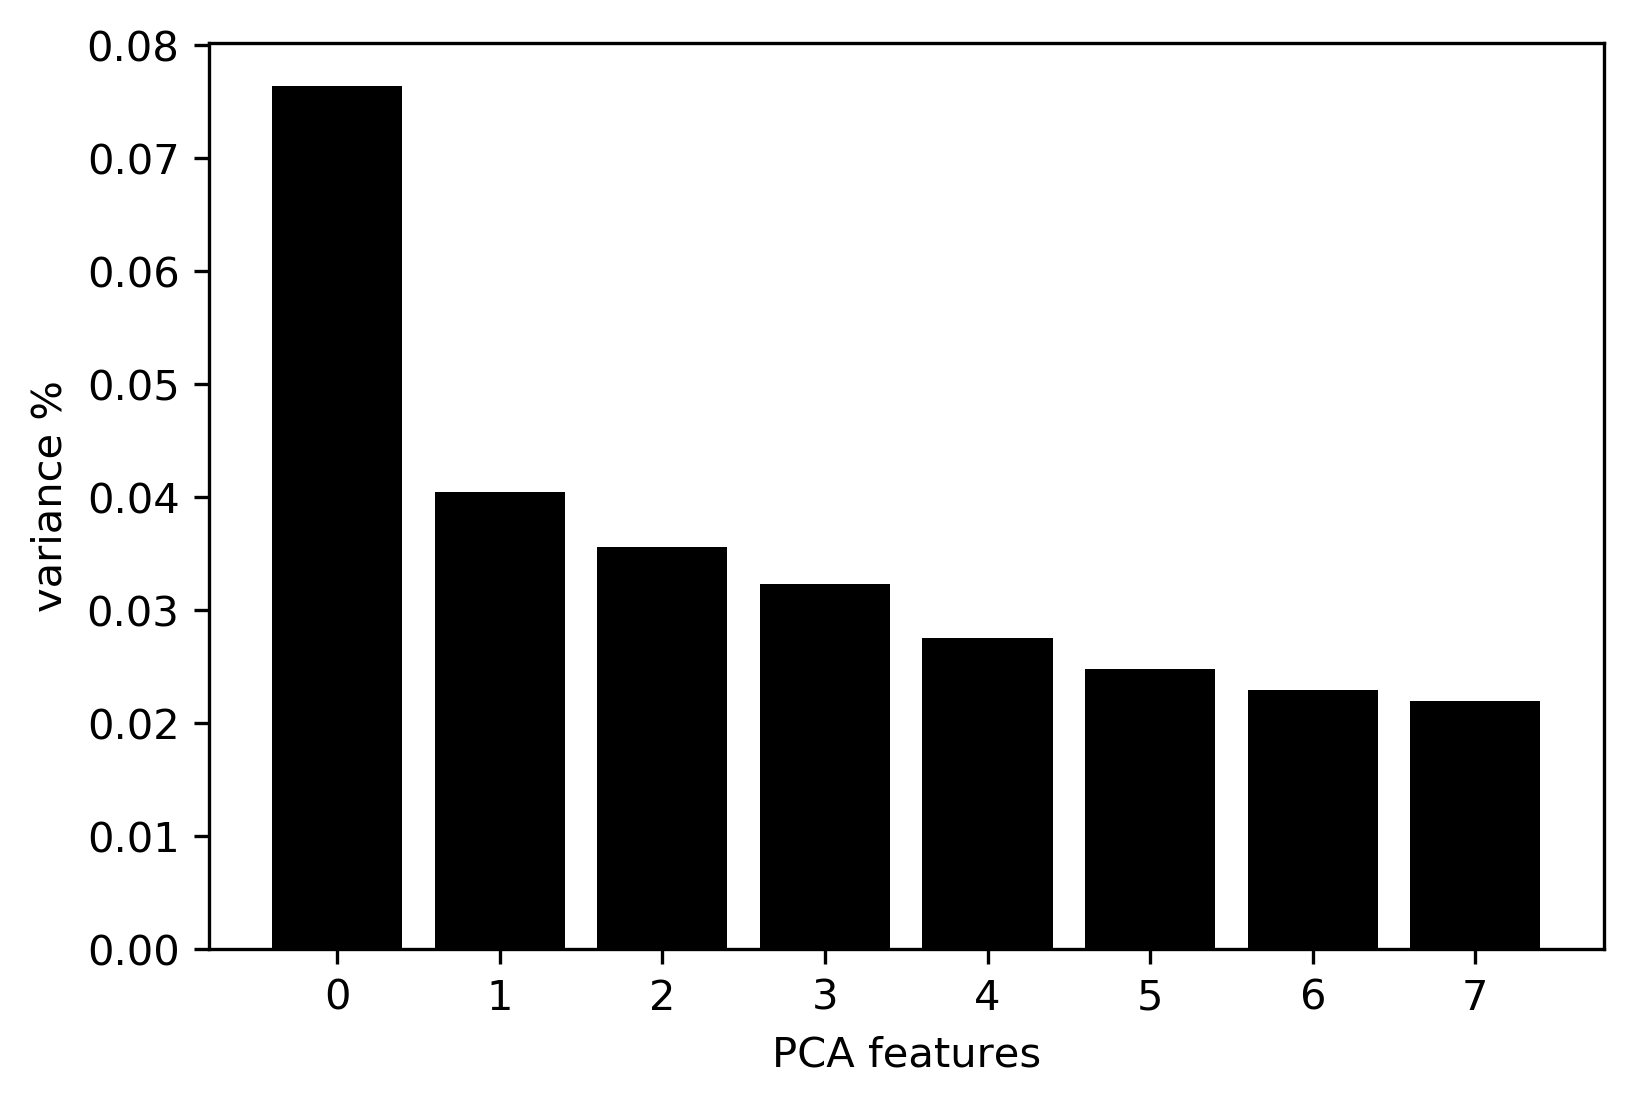

In [66]:
features = range(pca.n_components_)
plt.figure(dpi=300)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

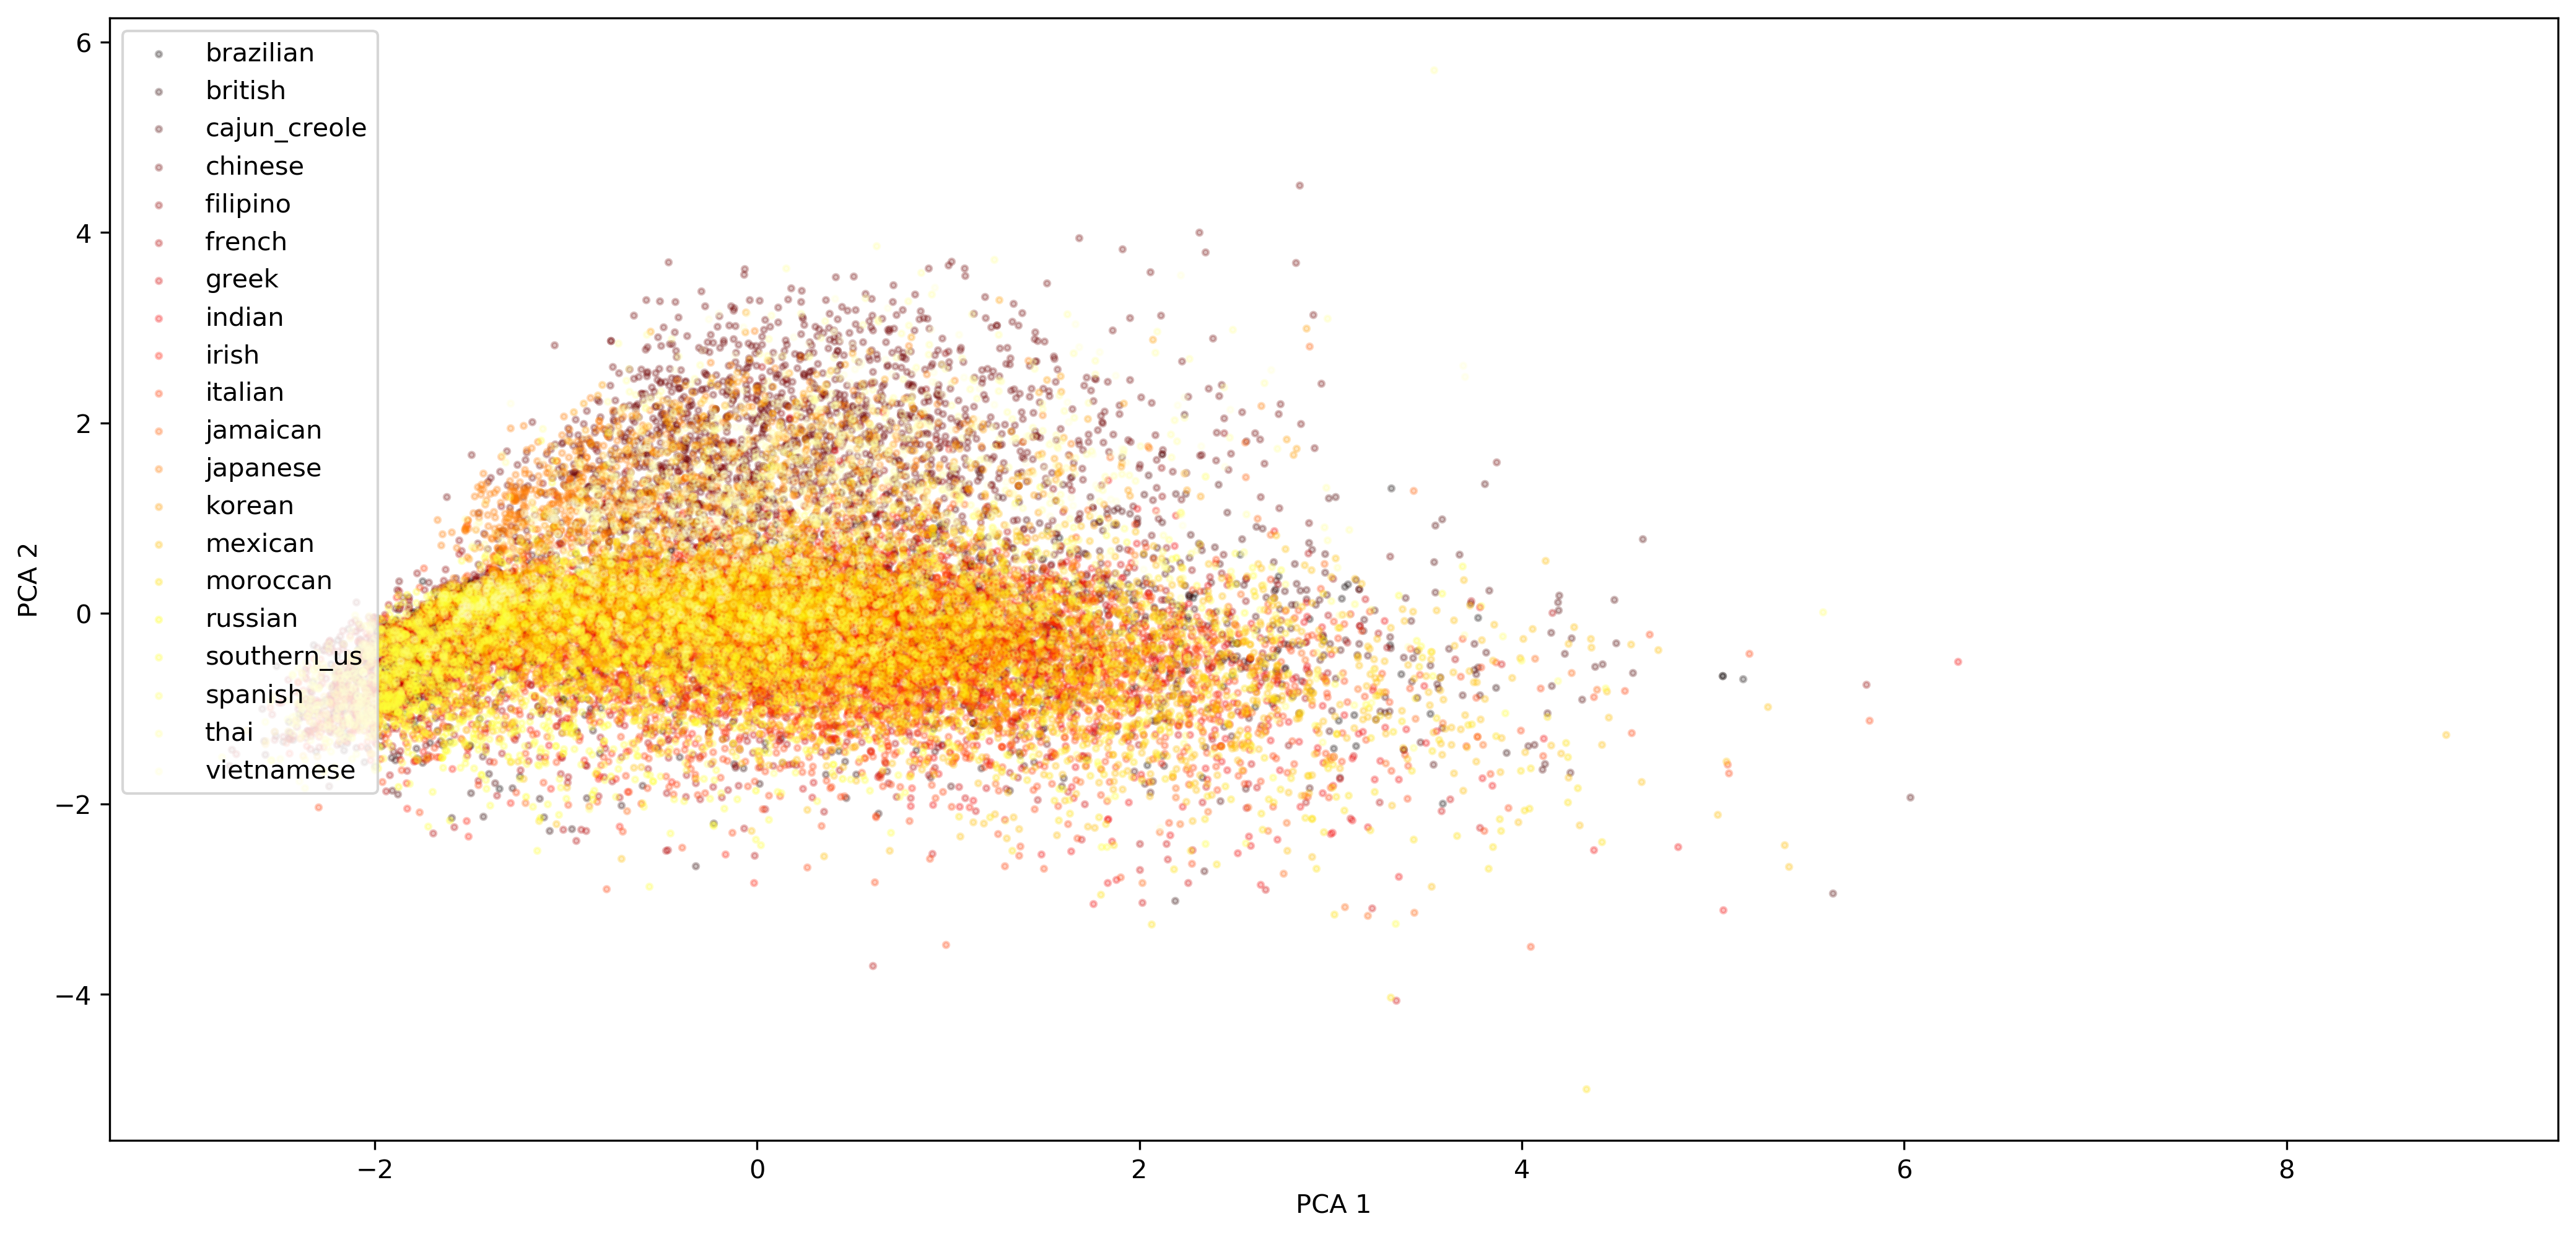

In [123]:
#plt.figure(dpi=300)
#plt.scatter(PCA_components[0], PCA_components[1], alpha=0.1, c=y_train,s=5)




plt.figure(figsize=(17,8),dpi=300)
#plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.1, c=y_train,s=5,label = )
#plt.xlabel('tsne-2d-one')
#plt.ylabel('tsne-2d-two')
#plt.legend(loc="upper left")
#plt.show()

import matplotlib.colors as colors
import matplotlib.cm as cmx
uniq = le.classes_

z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)


for i in range(len(uniq)):
    indx = le.inverse_transform(y_train) == uniq[i]
    plt.scatter(PCA_components[0][indx], PCA_components[1][indx],
                s=5,color = scalarMap.to_rgba(i), label=uniq[i],alpha = 0.25)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('')
plt.legend(loc='upper left')
plt.show()

In [124]:
#PCA_components[0]

# Scree Plot

1 clusters
2 clusters
3 clusters
4 clusters
5 clusters
6 clusters
7 clusters
8 clusters
9 clusters
10 clusters
11 clusters
12 clusters
13 clusters
14 clusters
15 clusters
16 clusters
17 clusters
18 clusters
19 clusters
20 clusters


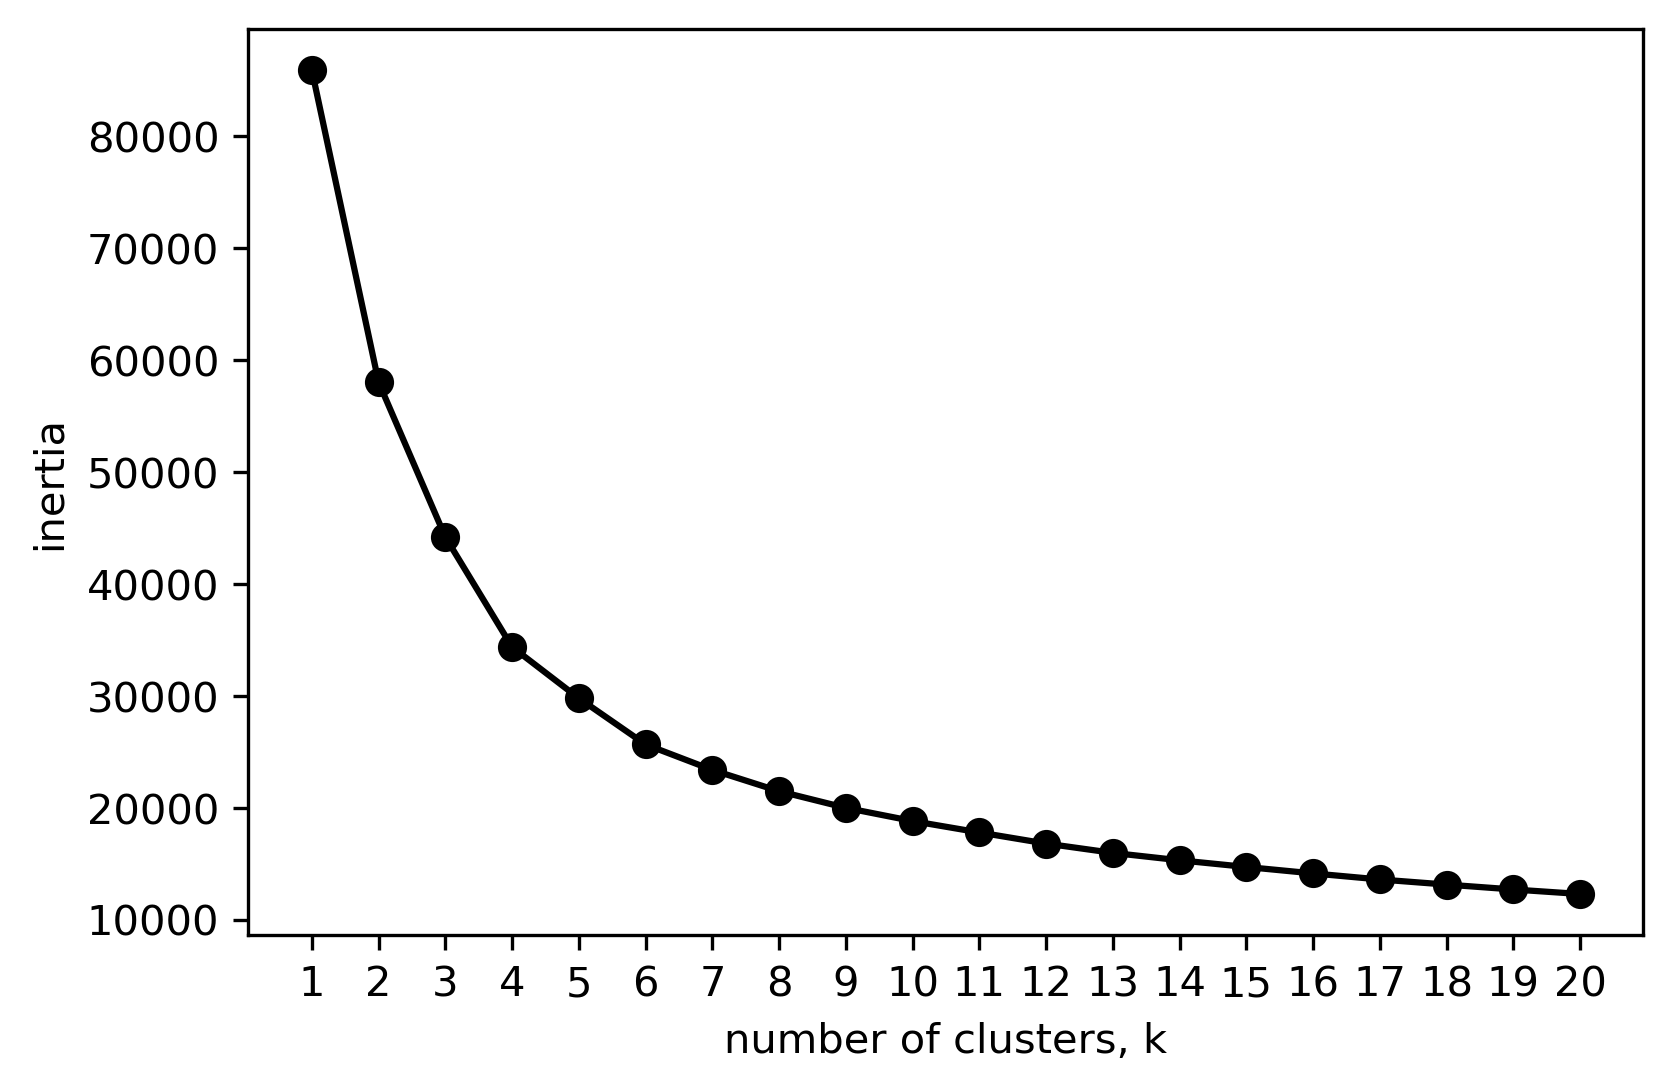

In [38]:
ks = range(1, 21)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
    print(k,'clusters')

plt.figure(dpi=300)    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [58]:
PCA_components

0         1         2         3         4         5         6  \
0     -1.064451 -0.592153  0.926799  0.043039 -0.370304  0.970293  0.226255   
1     -1.278813 -0.292398  1.061753 -0.344178 -0.583613  0.390795  0.207383   
2      0.499239  2.730730 -0.818487 -0.371668 -0.816470  0.292163  0.447772   
3     -1.145537  1.446529 -0.148204  0.603677  0.045700  0.123958  0.152553   
4      0.664067 -0.695972 -0.407626 -0.607097 -0.491588 -0.401135  0.501512   
...         ...       ...       ...       ...       ...       ...       ...   
27836  1.183956 -0.072959  2.819725  0.720210  0.670179  0.290363  0.328160   
27837  1.628007 -0.706064  1.235469 -1.734258  1.760619  0.015158  1.831036   
27838  1.987021 -0.991989 -1.086991  1.652007 -1.406861 -0.439267 -0.514916   
27839 -0.519139  0.232549  0.753502  0.187688  0.344277 -1.113565 -0.148003   
27840 -2.063015 -0.882974 -0.540059  1.161384  1.716051  0.884566  0.089310   

              7         8         9        10        11        12        13  \
0     -0.653045 -0.107269 -0.122314 -0.513588  0.097641 -0.175131 -0.695099   
1     -0.741360  0.134670 -0.065881 -0.120017 -0.277237  0.541183  0.108308   
2      0.705317 -0.386728  0.882797 -0.782211  0.035831  0.513338 -0.369947   
3     -0.780216  0.171375  0.592421 -0.122230 -0.045557 -0.318876  0.079482   
4      0.016944 -0.221369 -0.829961 -0.620732 -0.894495 -0.398674 -0.864419   
...         ...       ...       ...       ...       ...       ...       ...   
27836 -0.744314 -0.326113 -0.504930 -0.122972  0.374140 -0.083871  0.577952   
27837  0.043769 -0.916387 -0.367478 -0.133201 -0.156156 -0.057824  1.754982   
27838 -0.263039 -0.465676  0.820030 -0.090689  0.035913  1.467318 -0.629791   
27839  0.396055  0.239999 -0.467945  0.148978 -0.073782 -0.742490 -0.531021   
27840  0.081302 -0.310051  0.557056  0.048674  0.040428  0.070778  0.330844   

             14        15        16        17        18        19  
0     -0.422172 -0.128712 -0.519374  0.074357  0.607503 -0.471669  
1     -0.025071 -0.091362  0.228074 -0.157806  0.266251 -0.203831  
2      1.181223 -0.670291  0.244098 -0.111958 -0.030812 -0.317515  
3     -0.798150  0.421158  0.910113 -0.368879  0.317038  0.119795  
4     -0.315279 -0.016718  0.071637  0.105891 -0.468986 -0.134643  
...         ...       ...       ...       ...       ...       ...  
27836  0.743955  0.350854  1.022754 -1.138189 -0.585391 -0.329434  
27837  0.253052  0.365392  0.280144  0.135696 -0.357265  0.530486  
27838  0.660231  0.644494  0.462764  0.489623 -0.221097 -0.484749  
27839  0.428708 -0.225920  0.435071 -0.354368 -0.093773  0.546833  
27840 -0.196670  0.370595  0.188718  0.516028 -0.621749 -0.179077  

[27841 rows x 20 columns]

# TSNE

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 27841 samples in 12.047s...
[t-SNE] Computed neighbors for 27841 samples in 3013.613s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27841
[t-SNE] Computed conditional probabilities for sample 2000 / 27841
[t-SNE] Computed conditional probabilities for sample 3000 / 27841
[t-SNE] Computed conditional probabilities for sample 4000 / 27841
[t-SNE] Computed conditional probabilities for sample 5000 / 27841
[t-SNE] Computed conditional probabilities for sample 6000 / 27841
[t-SNE] Computed conditional probabilities for sample 7000 / 27841
[t-SNE] Computed conditional probabilities for sample 8000 / 27841
[t-SNE] Computed conditional probabilities for sample 9000 / 27841
[t-SNE] Computed conditional probabilities for sample 10000 / 27841
[t-SNE] Computed conditional probabilities for sample 11000 / 27841
[t-SNE] Computed conditional probabilities for sample 12000 / 27841
[t-SNE] Computed conditional probabilities fo

In [103]:
le.inverse_transform(y_train)

array(['mexican', 'southern_us', 'korean', ..., 'indian', 'greek',
       'russian'], dtype=object)

# plot

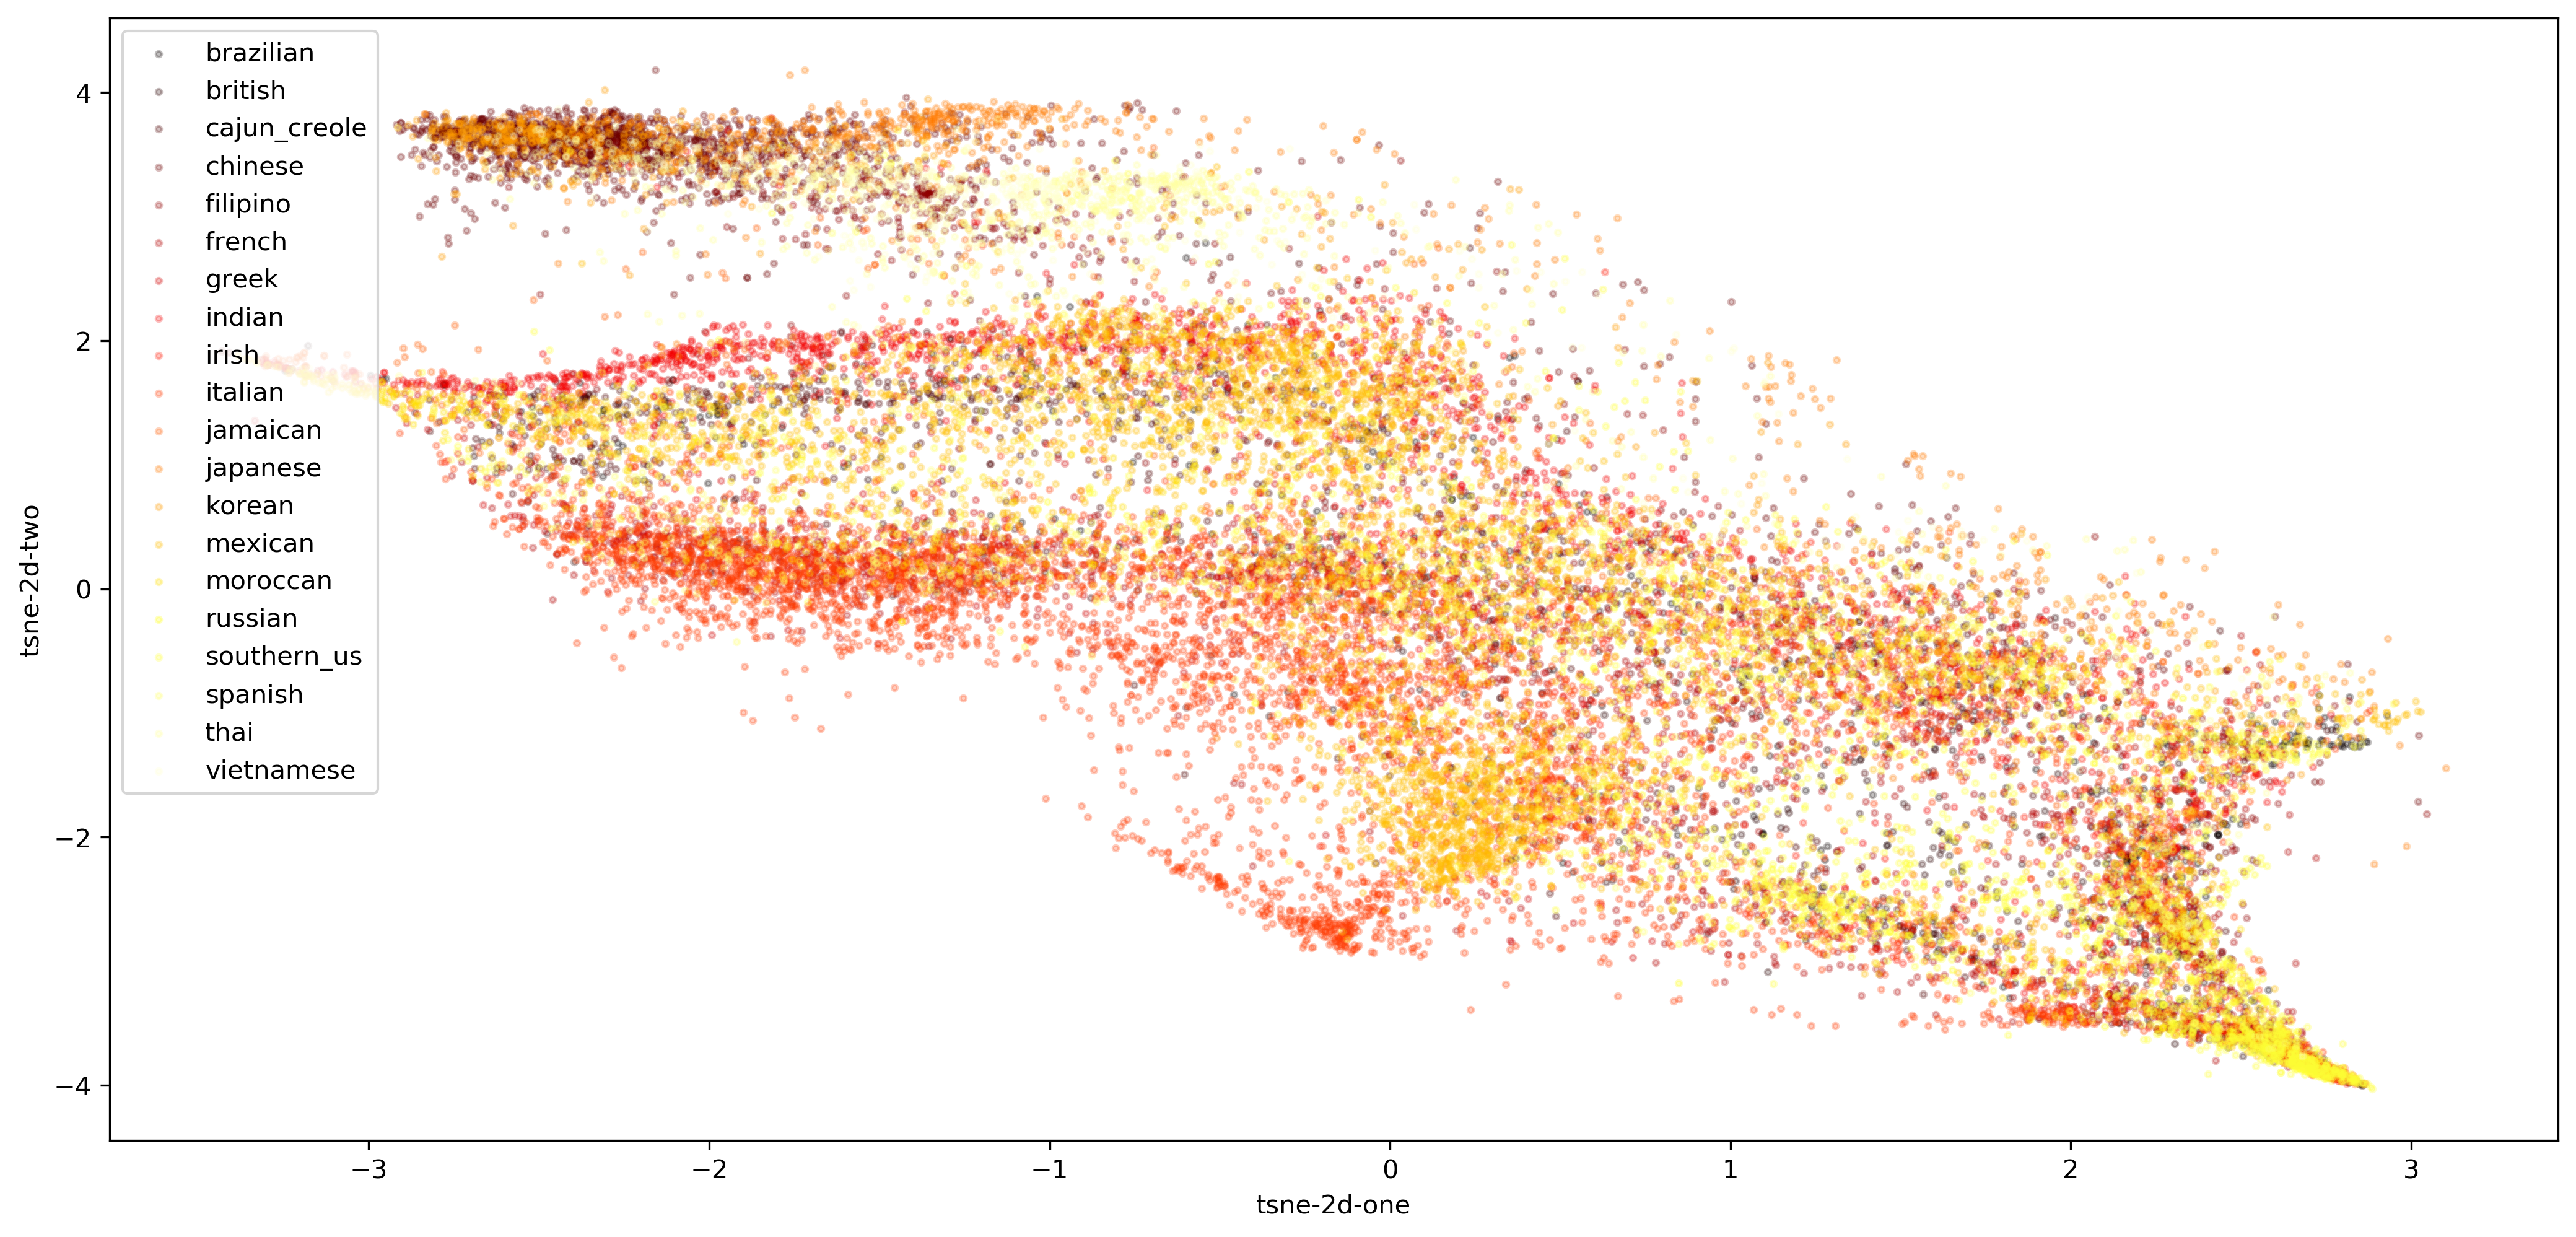

In [117]:
#X_train['tsne-2d-one'] = tsne_results[:,0]
#X_train['tsne-2d-two'] = tsne_results[:,1]
#import seaborn as sns
#sns.scatterplot(
#    x="tsne-2d-one", y="tsne-2d-two",
#    hue="y",
#    palette=sns.color_palette("hls", 10),
#    data=X_train,
#    legend="full",
#    alpha=0.3
#)

plt.figure(figsize=(17,8),dpi=300)
#plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.1, c=y_train,s=5,label = )
#plt.xlabel('tsne-2d-one')
#plt.ylabel('tsne-2d-two')
#plt.legend(loc="upper left")
#plt.show()

import matplotlib.colors as colors
import matplotlib.cm as cmx
uniq = le.classes_

z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)


for i in range(len(uniq)):
    indx = le.inverse_transform(y_train) == uniq[i]
    plt.scatter(tsne_results[indx,0], tsne_results[indx,1], s=5,color = scalarMap.to_rgba(i), label=uniq[i],alpha = 0.25)

plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.title('')
plt.legend(loc='upper left')
plt.show()